In [23]:
# Useful starting lines
%matplotlib inline

import pandas as pd
import numpy as np
import re
import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Transform data in sparse matrix

data = pd.read_csv('data_train.csv')

data.shape

r = re.compile(r'r(\d+)_c(\d+)')

def row_col(x, reg=r):
    result = r.findall(str(x))[0]

    return int(result[0]), int(result[1])

matrix = sp.dok_matrix((10000, 1000), np.int8)

for row in data.itertuples(False):
    tmp1, tmp2 = row_col(row[0], reg=r)
    matrix[tmp1-1, tmp2-1] = np.int8(row[1])

matrix = matrix.tocoo().tocsc()

#Matrix of 10000 users (row) x 1000 items (columns)
matrix

### Load Data

In [24]:
from helpers import load_data, preprocess_data

path_dataset = "data_train.csv"
data = load_data(path_dataset)

path_dataset2 = "sample_submission.csv"
sub_ex = load_data(path_dataset2)

number of users: 10000, number of items: 1000
number of users: 10000, number of items: 1000


In [25]:
sub_ex

<10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1176952 stored elements in LInked List format>

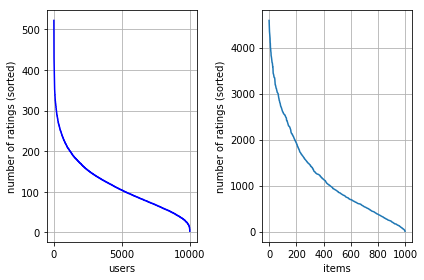

min # of items per user = 3, min # of users per item = 8.


In [258]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(data)
print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Reduce data set size

In [92]:
def reduce_data(ratings, size=0.01):
    """
    Reduce the size of the dataset for easier training and testing
    """
    # set seed
    np.random.seed(987)   
    
    # init
    num_rows, num_cols = ratings.shape
    
    selected_users = np.random.choice(np.arange(num_rows), size=int(size*num_rows), replace=False)
    selected_items = np.random.choice(np.arange(num_cols), size=int(size*num_cols), replace=False)
    selected_ratings = (ratings.copy())[selected_users, :][: , selected_items]  
        
    print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in reduced data:{v}".format(v=selected_ratings.nnz))

    return selected_ratings

In [94]:
reduced_data = reduce_data(data, size=0.1)

Total number of nonzero elements in original data:1176952
Total number of nonzero elements in reduced data:12872


### Split the data into a train and test set

In [95]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(987)
    
    # select user and item based on the condition.
    #valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    #valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings#[valid_users, :][: , valid_items]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_users, nz_items = valid_ratings.nonzero()
    
    # split the data
    for item in set(nz_items):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, item].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, item] = valid_ratings[residual, item]

        # add to test set
        test[selects, item] = valid_ratings[selects, item]

    print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in validated data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [96]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    data, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)

the shape of original ratings. (# of row, # of col): (1000, 100)
the shape of valid ratings. (# of row, # of col): (1000, 100)
Total number of nonzero elements in original data:12872
Total number of nonzero elements in validated data:12872
Total number of nonzero elements in train data:11691
Total number of nonzero elements in test data:1181


In [97]:
test

<1000x100 sparse matrix of type '<class 'numpy.float64'>'
	with 1181 stored elements in LInked List format>

### Load saved data

In [228]:
import pickle

In [229]:
"""train_f = open("train_save.csv", 'wb')
pickle.dump(train, train_f)
train_f.close()

test_f = open("test_save.csv", 'wb')
pickle.dump(test, test_f)
test_f.close()"""
pass

In [230]:
train_f = open("train_save.csv", 'rb')
train = pickle.load(train_f)
train_f.close()

test_f = open("test_save.csv", 'rb')
test = pickle.load(test_f)
test_f.close()

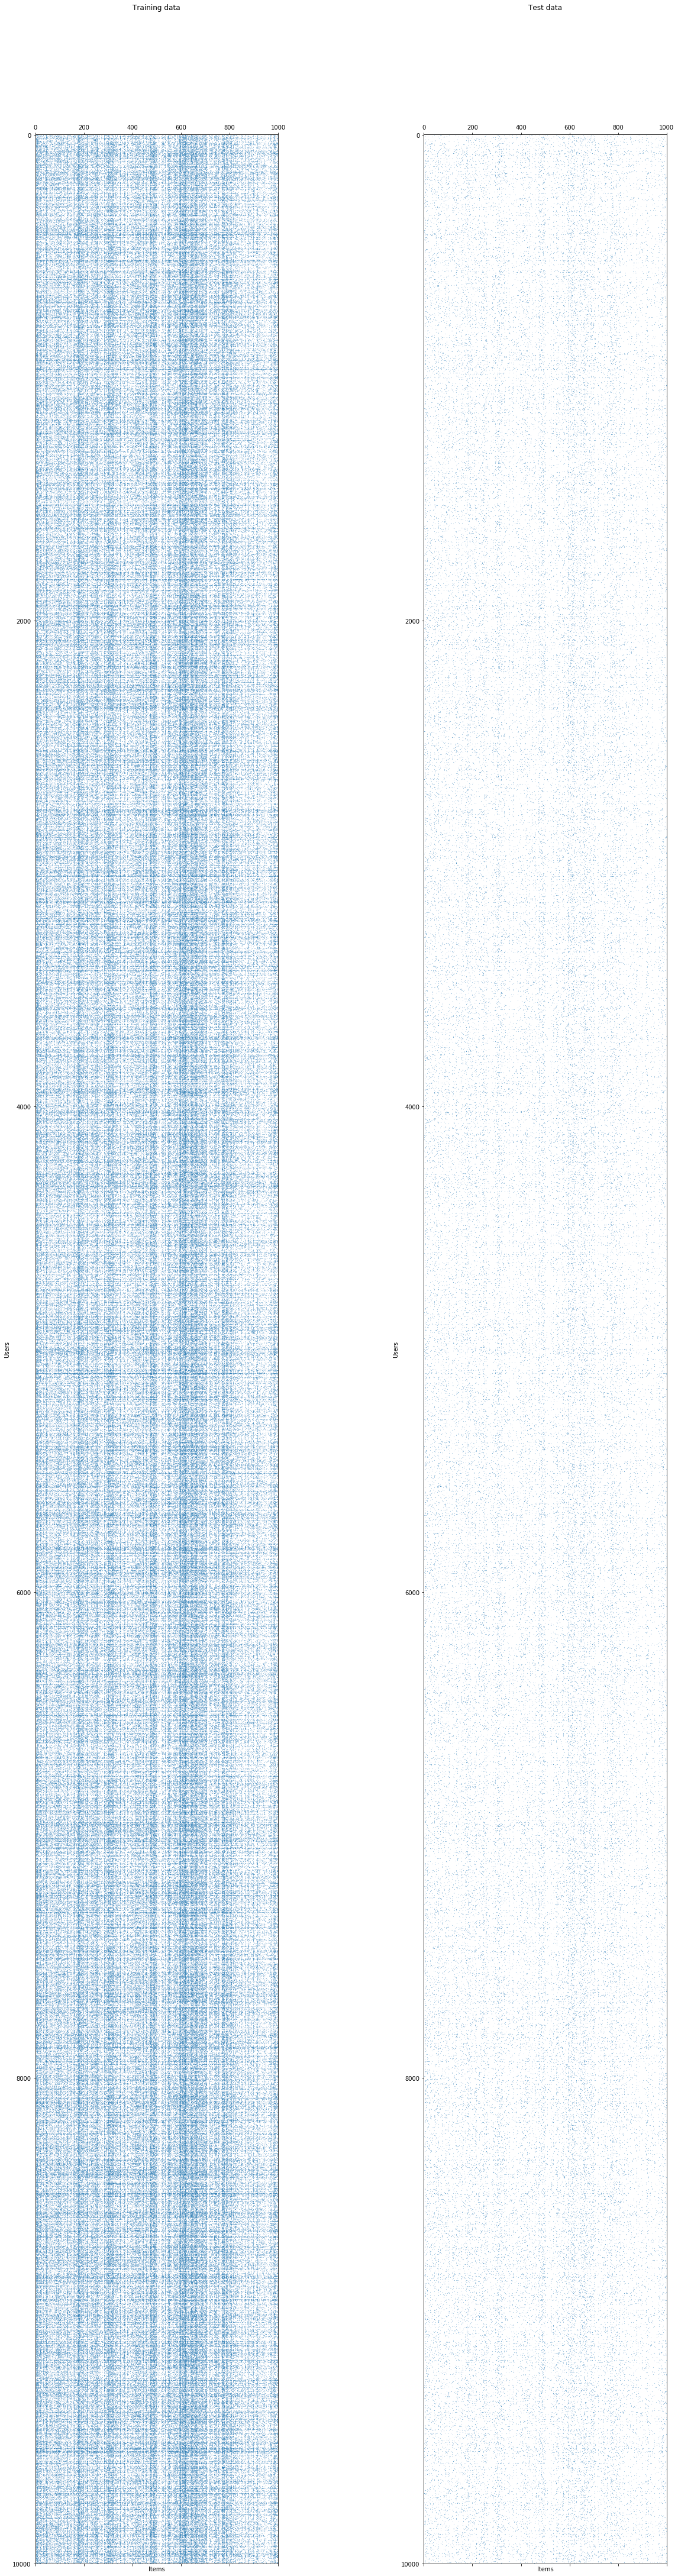

In [231]:
from plots import plot_train_test_data
plot_train_test_data(train, test)

### Baseline predictions

In [9]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    # find the non zero ratings in the train
    nonzero_train = train[train.nonzero()]

    # calculate the global mean
    global_mean_train = nonzero_train.mean()

    # find the non zero ratings in the test
    nonzero_test = test[test.nonzero()].todense()

    # predict the ratings as global mean
    mse = calculate_mse(nonzero_test, global_mean_train)
    rmse = np.sqrt(1.0 * mse / nonzero_test.shape[1])
    print("test RMSE of baseline using the global mean: {v}.".format(v=rmse))

#baseline_global_mean(train, test)

In [10]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_users, num_items = train.shape

    for user_index in range(num_users):
        # find the non-zero ratings for each user in the training dataset
        train_ratings = train[user_index, :]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            user_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each user in the test dataset
        test_ratings = test[user_index, :]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, user_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the user mean: {v}.".format(v=rmse))

#baseline_user_mean(train, test)

In [11]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_users, num_items = train.shape
    
    for item_index in range(num_items):
        # find the non-zero ratings for each item in the training dataset
        train_ratings = train[:, item_index]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]

        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            item_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each movie in the test dataset
        test_ratings = test[:, item_index]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, item_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the item mean: {v}.".format(v=rmse))
    
#baseline_item_mean(train, test)

### Learn the Matrix Factorization using SGD

In [31]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    num_user, num_item = train.get_shape()

    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)

    # start by item features.
    item_nnz = train.getnnz(axis=0)
    item_sum = train.sum(axis=0)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[0, ind] / item_nnz[ind]
        
    return user_features, item_features

In [32]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        user_info = user_features[:, row]
        item_info = item_features[:, col]
        mse += (data[row, col] - user_info.T.dot(item_info)) ** 2
    return np.sqrt((1.0 * mse) / (len(nz)))

In [125]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.02
    num_features = 100   # K in the lecture notes
    lambda_user = 0.09
    lambda_item = 0.09
    num_epochs = 20     # number of full passes through the train set
    errors_train = [0]
    errors_test = [0]
    
    # set seed
    np.random.seed(987)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for n, d in nz_train:
            # update W_d (item_features[:, d]) and Z_n (user_features[:, n])
            user_info = user_features[:, n]
            item_info = item_features[:, d]
            
            err = train[n, d] - user_info.T.dot(item_info)
    
            # calculate the gradient and update
            user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)
            item_features[:, d] += gamma * (err * user_info - lambda_item * item_info)

        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        rmse_te = compute_error(test, user_features, item_features, nz_test)
        print("          RMSE on testing set: {}.".format(rmse_te))
        
        errors_train.append(rmse)
        errors_test.append(rmse_te)

    # evaluate the test error
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    
    return user_features, item_features, errors_train, errors_test

In [126]:
W, Z, errors_tr, errors_te = matrix_factorization_SGD(train, test)  

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0703067524601628.
          RMSE on testing set: 1.1295952860772054.
iter: 1, RMSE on training set: 1.0100586258594166.
          RMSE on testing set: 1.0687541563292986.
iter: 2, RMSE on training set: 0.9832011663837117.
          RMSE on testing set: 1.0399492630045075.
iter: 3, RMSE on training set: 0.9719207733819927.
          RMSE on testing set: 1.0286236379518854.
iter: 4, RMSE on training set: 0.966760660657511.
          RMSE on testing set: 1.0241477997023567.
iter: 5, RMSE on training set: 0.959446826864157.
          RMSE on testing set: 1.0172907909088678.
iter: 6, RMSE on training set: 0.953840969683787.
          RMSE on testing set: 1.0116198557083107.
iter: 7, RMSE on training set: 0.9512079696465723.
          RMSE on testing set: 1.0087019122024017.
iter: 8, RMSE on training set: 0.9488642421484546.
          RMSE on testing set: 1.007140094373685.
iter: 9, RMSE on training set: 0.946450616

In [127]:
compute_error(test, W, Z, list(zip(*test.nonzero())))

0.99839302807691588

In [ ]:
1.0037878637263387

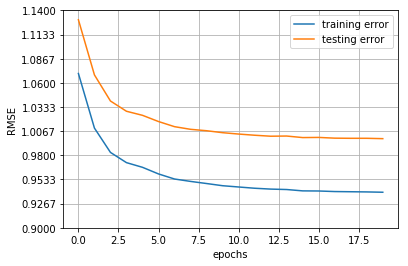

In [132]:
plt.plot(errors_tr[1:], label='training error')
plt.plot(errors_te[1:], label='testing error')
plt.yticks(np.linspace(0.9, 1.14, 10))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()
#plt.savefig("RMSE_SGD", dpi=200);

In [21]:
#pred = W.T@Z

In [22]:
#pred.shape

### Learn the Matrix Factorization using Alternating Least Squares with bias

In [134]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    
    for row, col in nz:
        item_info = item_features[:, col]
        user_info = user_features[:, row]

        mse += (data[row, col] - item_info.T.dot(user_info)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

In [135]:
def compute_error_final(data, user_features, item_features, nz, bias):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    
    user_bias = bias[1]
    item_bias = bias[2]
    mu = bias[0]
    
    for row, col in nz:
        item_info = item_features[:, col]
        user_info = user_features[:, row]

        mse += (data[row, col] - (mu + user_bias[row] + item_bias[col]) - item_info.T.dot(user_info)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

In [136]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    num_user, num_item = train.get_shape()

    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)

    # start by item features.
    item_nnz = train.getnnz(axis=0)
    item_sum = train.sum(axis=0)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[0, ind] / item_nnz[ind]
    return user_features, item_features

In [137]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices, bias):
    """update user feature matrix."""
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * sp.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    mu = bias[0] #train.mean()
    user_bias = bias[1] #train.mean(axis=1).flatten().T
    item_bias = bias[2] #train.mean(axis=0).flatten().T
        
    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        basis = train[user, items].copy().power(0)
        
        # update column row of user features
        V = M @ (train[user, items] - basis.multiply(mu + user_bias[user]) - item_bias[items].T).T
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:,user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices, bias):
    """update item feature matrix."""
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))
    
    mu = bias[0] #train.mean()
    user_bias = bias[1] #train.mean(axis=1).flatten().T
    item_bias = bias[2] #train.mean(axis=0).flatten().T

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        basis = train[users, item].copy().power(0)
        M = user_features[:, users]
        V = M @ (train[users, item] - basis.multiply(mu + item_bias[item]) - user_bias[users])
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:,item] = np.copy(X.T)
    return updated_item_features

In [191]:
from helpers import build_index_groups


def ALS(train, test, ratings):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 110   # K in the lecture notes
    lambda_user = 0.09
    lambda_item = 0.09
    stop_criterion = 1e-5
    change = 1
    change2 = -1
    error_train = [0, 0]
    error_test = [10, 9]
    
    # set seed
    np.random.seed(1042)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=1), train.getnnz(axis=0)
    
    nnz_test = list(zip(*test.nonzero()))
    
    # group the indices by row or column index
    nz_train, nz_user_itemindices, nz_item_userindices = build_index_groups(train)
    
    bias = ratings.mean(), ratings.mean(axis=1).flatten().T, ratings.mean(axis=0).flatten().T

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion and change2 < 0:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices, bias)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices, bias)

        error_tr = compute_error_final(train, user_features, item_features, nz_train, bias)
        print("RMSE on training set: {}.".format(error_tr))
        error_train.append(error_tr)
        
        error_te = compute_error_final(test, user_features, item_features, nnz_test, bias)
        print("        testing set: {}.".format(error_te))
        error_test.append(error_te)
        
        change = np.fabs(error_train[-1] - error_train[-2])
        change2 = error_test[-1] - error_test[-2]

    # evaluate the test error
    rmse = compute_error_final(test, user_features, item_features, nnz_test, bias)
    print("test RMSE after running ALS: {v}.".format(v=rmse))
    
    return user_features, item_features, error_train, error_test, bias

In [192]:
W, Z, error_tr, error_te, bias = ALS(train, test, data)


start the ALS algorithm...
RMSE on training set: [[ 1.25007678]].
        testing set: [[ 1.37502368]].
RMSE on training set: [[ 0.94800073]].
        testing set: [[ 1.06756437]].
RMSE on training set: [[ 0.90192496]].
        testing set: [[ 1.02335727]].
RMSE on training set: [[ 0.88001668]].
        testing set: [[ 1.00635024]].
RMSE on training set: [[ 0.86696064]].
        testing set: [[ 0.99801039]].
RMSE on training set: [[ 0.85837079]].
        testing set: [[ 0.99334568]].
RMSE on training set: [[ 0.85239428]].
        testing set: [[ 0.99049833]].
RMSE on training set: [[ 0.84807576]].
        testing set: [[ 0.98864545]].
RMSE on training set: [[ 0.84486603]].
        testing set: [[ 0.98737978]].
RMSE on training set: [[ 0.84242733]].
        testing set: [[ 0.98648233]].
RMSE on training set: [[ 0.84054115]].
        testing set: [[ 0.98582705]].
RMSE on training set: [[ 0.83906]].
        testing set: [[ 0.98533725]].
RMSE on training set: [[ 0.83788106]].
        test

In [218]:
error_tr2 = [x.item() for x in error_tr[2:]]
error_te2 = [x.item() for x in error_te[2:]]

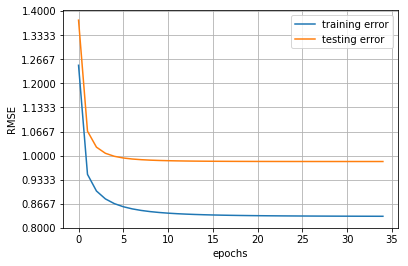

In [277]:
plt.plot(error_tr2, label='training error')
plt.plot(error_te2, label='testing error')
plt.yticks(np.linspace(0.8, 1.4, 10))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("RMSE_ALS_BIAS", dpi=200);

In [ ]:
test RMSE after running ALS: [ 0.984748]

In [222]:
pred = W.T@Z

In [223]:
path_dataset2 = "sample_submission.csv"
sub_ex = load_data(path_dataset2)

number of users: 10000, number of items: 1000


In [224]:
import csv

def create_csv_submission(pred_nonzero, approx, train, name, bias, round_=False):
    mu = bias[0]#train.mean()
    user_bias = bias[1] #train.mean(axis=1).flatten().T
    item_bias = bias[2] #train.mean(axis=0).flatten().T
    
    nnz_row, nnz_col = train.nonzero()
    
    with open(name, 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for row, col in pred_nonzero:
            ids = 'r' + str(row+1) + '_c' + str(col+1)
            
            b = mu + user_bias[row] + item_bias[col]
            
            if round_:
                value = round(approx[row, col] + b)
            else:
                value = approx[row, col] + b
                
            value = value.item(0)
                
            writer.writerow({'Id':ids,'Prediction':value})
            
create_csv_submission(list(zip(*sub_ex.nonzero())), pred, train, 'potato2.csv', bias)

### Learn the Matrix Factorization using Alternating Least Squares

In [142]:
def compute_global_mean(data):
    """baseline method: use the global mean."""
    # find the non zero ratings in the train
    nonzero_data = data[data.nonzero()]

    # calculate the global mean
    global_mean_data = nonzero_data.mean()

    return global_mean_data

mu = compute_global_mean(train)

In [143]:
def compute_user_mean(data, mu):
    """baseline method: use the user means as the prediction."""
    num_users, num_items = data.shape
    user_mean = np.zeros(num_users)
    
    for user_index in range(num_users):
        # find the non-zero ratings for each user in the training dataset
        ratings = data[user_index, :]
        nonzeros_ratings = ratings[ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_ratings.shape[0] == 0:
            user_mean[user_index] = 0
        else:
            user_mean[user_index] = nonzeros_ratings.mean() - mu
    
    return user_mean

b_u = compute_user_mean(train, mu)

In [144]:
def compute_item_mean(data, mu):
    """baseline method: use the user means as the prediction."""
    num_users, num_items = data.shape
    item_mean = np.zeros(num_items)
    
    for item_index in range(num_items):
        # find the non-zero ratings for each item in the training dataset
        ratings = data[:, item_index]
        nonzeros_ratings = ratings[ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_ratings.shape[0] == 0:
            item_mean[item_index] = 0
        else:
            item_mean[item_index] = nonzeros_ratings.mean() - mu
    
    return item_mean

b_i = compute_item_mean(train, mu)

In [262]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * sp.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        
        # update column row of user features
        V = M @ train[user, items].T
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:, user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        M = user_features[:, users]
        
        # update column row of item features
        V = M @ train[users, item]
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:, item] = np.copy(X.T)
    return updated_item_features

In [263]:
from helpers import build_index_groups


def ALS(train, test, num_features, lambda_user, lambda_item, stop_criterion=1e-04):
    
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    #num_features = 50   # K in the lecture notes
    #lambda_user = 0.1
    #lambda_item = 0.07
    #stop_criterion = 1e-4
    change = 1
    change2 = -1
    error_list_train = [0, 0]
    error_list_test = [10, 9]
    
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    
    # set seed
    np.random.seed(1042)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_users_per_item, nnz_items_per_user = train.getnnz(axis=0), train.getnnz(axis=1)
    
    # group the indices by row or column index
    nz_train, nz_user_itemindices, nz_item_userindices = build_index_groups(train)

    # run ALS
    print("\nstart the ALS algorithm...")
    try:
        while change > stop_criterion and change2 < 0:
            # update user feature & item feature
            user_features = update_user_feature(
                train, item_features, lambda_user,
                nnz_items_per_user, nz_user_itemindices)
            item_features = update_item_feature(
                train, user_features, lambda_item,
                nnz_users_per_item, nz_item_userindices)

            error_tr = compute_error(train, user_features, item_features, nz_train)
            error_te = compute_error(test, user_features, item_features, nnz_test)
            print("RMSE on training set: {}.".format(error_tr))
            print("            test set: {}.".format(error_te))
            
            error_list_train.append(error_tr)
            error_list_test.append(error_te)
            change = np.fabs(error_list_train[-1] - error_list_train[-2])
            change2 = error_list_test[-1] - error_list_test[-2]
    except (KeyboardInterrupt, SystemExit):
        print("Stopping algorithm...")
    except:
        raise
    
    # evaluate the test error
    rmse_test = compute_error(test, user_features, item_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse_test))
    
    
    return user_features, item_features, rmse_test, error_list_train, error_list_test

In [264]:
lambdas_user = np.linspace(0.1, 0.1, 1)
lambdas_item = np.linspace(0.1, 0.1, 1)
W_l = []
Z_l = []
errors_test = []

In [265]:
min_error = 10
best_l_u = 0
best_l_i = 0
best_W = 0
best_Z = 0

for l_u in lambdas_user:
    for l_i in lambdas_item:
        print("""
        ===================
        lambda_user = {}  lambda_item = {}
        ===================
        """.format(l_u, l_i))
        
        #W, Z, rmse = ALS(train, test, 400, l_u, l_i, 1e-03)
        W, Z, rmse, error_l_tr, error_l_te = ALS(train, test, 110, 0.09 , 0.09, 1e-05)
        W_l.append(W)
        Z_l.append(Z)
        errors_test.append(rmse)
        if rmse < min_error:
            min_error = rmse
            best_l_u = l_u
            best_l_i = l_i
            best_W = W
            best_Z = Z        


        lambda_user = 0.1  lambda_item = 0.1
        

start the ALS algorithm...
RMSE on training set: 1.125279417667879.
            test set: 1.2447193228342892.
RMSE on training set: 0.9616829621617272.
            test set: 1.0758811352293791.
RMSE on training set: 0.9240766635641702.
            test set: 1.0430081129136632.
RMSE on training set: 0.9001707037705698.
            test set: 1.0252213544438653.
RMSE on training set: 0.8841713188063247.
            test set: 1.0143606433113548.
RMSE on training set: 0.8729964968399094.
            test set: 1.0072246144630037.
RMSE on training set: 0.8649106403214764.
            test set: 1.0022784255678514.
RMSE on training set: 0.8588869023075058.
            test set: 0.9987046953503751.
RMSE on training set: 0.8542895219197045.
            test set: 0.996035527521675.
RMSE on training set: 0.8507093364839684.
            test set: 0.9939873596337223.
RMSE on training set: 0.8478735725755941.
            test set: 0.9923801364026

In [65]:
print("Best test error = {}\nlambda_user = {}\nlambda_item = {}".format(min_error, best_l_u, best_l_i))

Best test error = 0.9838036374346791
lambda_user = 0.1
lambda_item = 0.1


Best test error = 0.9837976887068574
lambda_user = 0.09
lambda_item = 0.09

In [66]:
compute_error(test, best_W, best_Z, list(zip(*test.nonzero())))

0.98380363743467913

$Best-test-error = 0.98378142473540953$

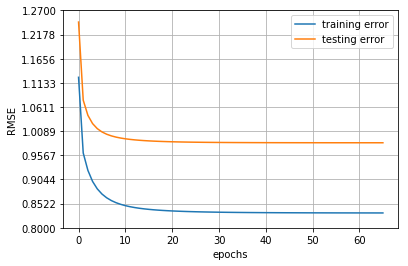

In [274]:
plt.plot(error_l_tr[2:], label='training error')
plt.plot(error_l_te[2:], label='testing error')
plt.yticks(np.linspace(0.8, 1.27, 10))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()
#plt.savefig("RMSE_ALS", dpi=200);

In [67]:
pred = best_W.T@best_Z

In [68]:
pred.shape

(10000, 1000)

### External library : Nimfa

In [257]:
import nimfa
from nimfa.utils.linalg import ceil

C:\Anaconda3\lib\site-packages\nimfa\examples\cbcl_images.py:98: UserWarning: PIL must be installed to run CBCL images example.
  warn("PIL must be installed to run CBCL images example.")
C:\Anaconda3\lib\site-packages\nimfa\examples\orl_images.py:110: UserWarning: PIL must be installed to run ORL images example.
  warn("PIL must be installed to run ORL images example.")


In [23]:
def initialize_matrices(V, rank, seed=None):
        """
        Return initialized basis and mixture matrix. Initialized matrices are of
        the same type as passed target matrix.
        """
        rank = rank
        p_c = int(ceil((1. / 5) * V.shape[1]))
        p_r = int(ceil((1. / 5) * V.shape[0]))
        prng = np.random.RandomState(seed)
        if sp.isspmatrix(V):
            W = sp.lil_matrix((V.shape[0], rank))
            H = sp.lil_matrix((rank, V.shape[1]))
        else:
            W = np.mat(np.zeros((V.shape[0], rank)))
            H = np.mat(np.zeros((rank, V.shape[1])))
        for i in range(rank):
            W[:, i] = V[:, prng.randint(low=0, high=V.shape[1], size=p_c)].mean(axis=1)
            H[i, :] = V[prng.randint(low=0, high=V.shape[0], size=p_r), :].mean(axis=0)
        # return sparse or dense initialization
        if sp.isspmatrix(V):
            return W.tocsr(), H.tocsr()
        else:
            return W, H

In [24]:
V = train.copy()
"""V = np.matrix(np.random.randint(0, 6, (20, 20), np.int))
print('Target:\n%s' % V)"""

rank_ = 100
W_, Z_ = initialize_matrices(V, rank_, seed=420)

lsnmf = nimfa.Lsnmf(V, seed=None, W=W_, H=Z_, max_iter=100, rank=rank_)
lsnmf_fit = lsnmf()

W_pred = lsnmf_fit.basis()
Z_pred = lsnmf_fit.coef()

In [25]:
ww = W_pred.T.todense()
zz = Z_pred.todense()

In [27]:
compute_error(test, np.array(ww), np.array(zz), list(zip(*test.nonzero())))

3.4890327978799656

In [ ]:
zz.shape

### Using pyspark library mllib

In [238]:
import findspark
findspark.init()

In [239]:
import pyspark
sc = pyspark.SparkContext(master="local[3]", appName="ML project 2")

In [241]:
sc

<SparkContext master=local[3] appName=ML project 2>

In [242]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [243]:
def row_col_spark(x, reg):
    result = r.findall(str(x))[0]
    return int(result[0])-1, int(result[1])-1

In [244]:
r = re.compile(r'r(\d+)_c(\d+)')

In [245]:
def split_p(p):
    return np.random.rand() < p

In [246]:
# Load and parse the data
data2 = sc.textFile("data_train.csv")
header = data2.first() #extract header
data2 = data2.filter(lambda row: row != header) 

ratings = data2.map(lambda l: l.split(','))
ratings = ratings.map(lambda l: Rating(*row_col_spark(l[0], r), float(l[1])))
train2, test2 = ratings.randomSplit([0.9, 0.1], seed=4242)

#Need to cache the data to speed up training
train2.cache()
test2.cache()

sc.setCheckpointDir('checkpoint/')

In [248]:
lambdas_spark = [0.09]
ranks_spark = [100]

for l_s in lambdas_spark:
    for r_s in ranks_spark:
        print("""
        ============================
        lambda = {}   rank = {}
        ============================
        """.format(l_s, r_s))
        
        # Build the recommendation model using Alternating Least Squares
        rank = r_s
        numIterations = 230
        lambda_spark = l_s
        model = ALS.train(train2, rank, numIterations, lambda_=lambda_spark, nonnegative=True, seed=459832632)

        #TRAIN RMSE
        train_input = train2.map(lambda x:(x[0],x[1]))   
        pred_train = model.predictAll(train_input) 

        true_train = train2.map(lambda x:((x[0],x[1]), x[2]))
        pred_train = pred_train.map(lambda x:((x[0],x[1]), x[2]))

        true_pred = true_train.join(pred_train)

        MSE_train = true_pred.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        RMSE_train = np.sqrt(MSE_train)

        #TEST RMSE
        test_input = test2.map(lambda x:(x[0],x[1])) 
        pred_test = model.predictAll(test_input)

        true_test = test2.map(lambda x:((x[0],x[1]), x[2]))
        pred_test = pred_test.map(lambda x:((x[0],x[1]), x[2]))

        true_pred = true_test.join(pred_test)

        MSE_test = true_pred.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        RMSE_test = np.sqrt(MSE_test)

        print("Train rmse : ", RMSE_train)
        print("Test rmse : ", RMSE_test)

        # Evaluate the model on training data
        #testdata = ratings.map(lambda p: (p[0], p[1]))
        #predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
        #pred = predictions.collect()
        #ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        #MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        #print("Mean Squared Error = " + str(MSE))


        lambda = 0.09   rank = 100
        
Train rmse :  0.845663674656
Test rmse :  0.987685817513


In [ ]:
       ============================
        lambda = 0.09   rank = 100 nbIter = 250
        ============================
        
Train rmse :  0.845663674656
Test rmse :  0.987685817513


In [214]:
# Save and load model
#model.save(sc, "spark_model")
#sameModel = MatrixFactorizationModel.load(sc, "target/tmp/myCollaborativeFilter")

In [249]:
testdata = sc.textFile("sample_submission.csv")
testheader = testdata.first() #extract header
testdata = testdata.filter(lambda row: row != testheader) 
testdata = testdata.map(lambda l: l.split(','))
testdata = testdata.map(lambda l: (row_col_spark(l[0], r)))

predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
pred = predictions.collect()

In [250]:
"""file = open("spark_pred", "wb")
pickle.dump(pred, file)
file.close()"""
pass

In [251]:
matrix_pred = sp.dok_matrix((10000, 1000), dtype=np.float32)

for row in pred:
    matrix_pred[row[0][0], row[0][1]] = row[1]

In [252]:
matrix_pred[155, 0]

3.7789688

In [150]:
test

<10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 111598 stored elements in LInked List format>

In [253]:
def compute_error_pred(data, pred, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        mse += (data[row, col] - pred[row, col]) ** 2
    return np.sqrt((1.0 * mse) / (len(nz)))

In [254]:
compute_error_pred(test, matrix_pred, list(zip(*test.nonzero())))

4.0208521610837842

### Creating submission

In [238]:
"""sub = pd.DataFrame(columns=['Id', 'Prediction'])
sub.to_csv("prediction.csv", index=False)

for i, row in enumerate(sub_ex.itertuples(False)):
    tmp1, tmp2 = row_col(row[0], reg=r)
    value = round(pred[tmp1-1, tmp2-1])
    
    sub = sub.append({'Id':'r'+str(tmp1)+'_c'+str(tmp2),'Prediction':value}, ignore_index=True)
    
    if i%1000 == 0:
        print(round(100*i/sub_ex.shape[0], 3), "% completed")
        sub.to_csv("prediction.csv", index=False, header=False, mode='a')
        sub = pd.DataFrame(columns=['Id', 'Prediction'])
        
print("100% completed")
sub.to_csv("prediction.csv", index=False, header=False, mode='a')
sub = pd.DataFrame(columns=['Id', 'Prediction'])"""
pass

In [255]:
import csv

def create_csv_submission(pred_nonzero, approx, name, round_=False):
    with open(name, 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for row, col in pred_nonzero:
            ids = 'r' + str(row+1) + '_c' + str(col+1)
            
            if round_:
                value = round(approx[row, col])
            else:
                value = approx[row, col]
                
            writer.writerow({'Id':ids,'Prediction':value})
            
create_csv_submission(list(zip(*sub_ex.nonzero())), matrix_pred, 'banana_republic.csv')